# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png)

##  Project Capstone

### Reducing Electricity Costs in Romania: Predictive and Reinforcement Learning for Solar Power Optimization

---

[README](../README.md) | [Part 1: Cleaning](01_Cleaning.ipynb) | [Part 2: EDA](02_EDA.ipynb) | [Part 3: Solar Energy Prediction Models](03_Model_Solar_Energy.ipynb) | **Part 4: Electricity Cost Prediction Models** | [Part 5: Electricity Cost Prediction Using Time Series Models](05_Model_Electricity_Cost_ts.ipynb)

---

### Introduction
- In this section, various models will be developed to predict electricity cost from energy production using different types of algorithms.
- The results will then be compared based on the R-squared metric.

### Import and Preprocessing

#### Essential Libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import xgboost as xgb
import statsmodels.api as sm

np.random.seed(42)

#### Import Data

In [35]:
df = pd.read_csv('../data/cleaned/electricity_romania.csv')       # Import
df['datetime'] = pd.to_datetime(df['datetime'])                   # Formatting `datetime`
df['month'] = df['datetime'].dt.month                             # Extract month
df['hour'] = df['datetime'].dt.hour                               # Extract hour

In [36]:
df.head(1)

,datetime,temp,feelslike,dew,humidity,windgust,windspeed,winddir,sealevelpressure,cloudcover,...,production,nuclear,wind,hydroelectric,oil_gas,coal,solar,biomass,month,hour
0,2024-01-01,3.4,3.4,2.9,96.47,6.1,3.7,19.0,1018.1,0.0,...,6223,1396,1115,1409,1434,837,0,31,1,0


In [37]:
df.columns

Index(['datetime', 'temp', 'feelslike', 'dew', 'humidity', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'has_snow', 'has_solarradiation', 'icon_cloudy', 'icon_fog',
       'icon_partly_cloudy', 'icon_rain', 'icon_snow', 'ckwh', 'consumption',
       'production', 'nuclear', 'wind', 'hydroelectric', 'oil_gas', 'coal',
       'solar', 'biomass', 'month', 'hour'],
      dtype='object')

In [38]:
df = df[['datetime'
         , 'consumption'
         , 'production'
         , 'nuclear'
         , 'wind'
         , 'hydroelectric'
         , 'oil_gas'
         , 'coal'
         , 'solar'
         , 'biomass'
         , 'month'
         , 'hour'
         , 'ckwh'
        ]]

#### Preprocessing
- Add a new column `excess` which is the difference of `production` and `consumption`
- Convert `month` and `hour` using `OneHotEncoder`, and drop January and 0 AM as the baseline.

In [39]:
df['excess'] = df['production'] - df['consumption']

In [40]:
# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output = False)

# Fit and transform the 'month' and 'hour' columns
encoded_df = encoder.fit_transform(df[['month', 'hour']])

# Create a DataFrame with the encoded columns
encoded_df = pd.DataFrame(encoded_df, columns = encoder.get_feature_names_out(['month', 'hour']))

# Concatenate the original DataFrame with the encoded columns
df = pd.concat([df, encoded_df], axis = 1)

# Drop the original 'datetime', 'month', and 'hour' columns 
# Drop the baseline 'month_1' and 'hour_0' columns
df.drop(['datetime', 'month', 'hour', 'month_1', 'hour_0'], axis = 1, errors = 'ignore', inplace = True)

df.head()

,consumption,production,nuclear,wind,hydroelectric,oil_gas,coal,solar,biomass,ckwh,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,5338,6223,1396,1115,1409,1434,837,0,31,1.07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5148,5775,1396,1228,870,1420,825,0,31,1.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4931,5904,1395,1351,868,1424,836,0,31,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4836,5879,1400,1344,837,1424,843,0,32,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4556,5865,1398,992,868,1401,788,0,31,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Electricity Cost Prediction Models

#### Ordinary Linear Regression
- The default model achieved an R-squared of 0.72 on the training set and 0.69 on the testing set.

In [41]:
# Set X, y
X = df.drop('ckwh', axis = 1)
y = df['ckwh']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [42]:
# Baseline Model, predict using mean

# Instantitate
model_baseline = DummyRegressor(strategy = 'mean')

# Fit
model_baseline.fit(X_train, y_train)

# Predictions
model_baseline_y_preds_train = model_baseline.predict(X_train)
model_baseline_y_preds_test = model_baseline.predict(X_test)

# Train: RMSE, R-squared
model_baseline_rmse_train = np.sqrt(mean_squared_error(y_train, model_baseline_y_preds_train))
model_baseline_rsq_train = r2_score(y_train, model_baseline_y_preds_train)

# Test: RMSE, R-squared
model_baseline_rmse_test = np.sqrt(mean_squared_error(y_test, model_baseline_y_preds_test))
model_baseline_rsq_test = r2_score(y_test, model_baseline_y_preds_test)

print(f'Baseline Model Root Mean Square Error: \nTrain: {model_baseline_rmse_train:.2f} \nTest: {model_baseline_rmse_test:.2f}')
print(f'Baseline Model R-squared: \nTrain:{model_baseline_rsq_train:.2f} \nTest: {model_baseline_rsq_test:.2f}')

Baseline Model Root Mean Square Error: 
Train: 2.83 
Test: 2.73
Baseline Model R-squared: 
Train:0.00 
Test: -0.00


In [43]:
# Linear Regression

# Add a constant
X_train_lr = sm.add_constant(X_train)
X_test_lr = sm.add_constant(X_test)

# Fit
model_lr = sm.OLS(y_train, X_train_lr).fit()

# Predictions
model_lr_y_train_preds = model_lr.predict(X_train_lr)
model_lr_y_test_preds = model_lr.predict(X_test_lr)

# Calculate RMSE for training and test data
model_lr_train_rmse = np.sqrt(mean_squared_error(y_train, model_lr_y_train_preds))
model_lr_test_rmse = np.sqrt(mean_squared_error(y_test, model_lr_y_test_preds))

# R-squared and Adjusted R-squared for training data
model_lr_train_rsq = model_lr.rsquared
model_lr_train_adj = model_lr.rsquared_adj

# R-squared for test data
ss_total = np.sum((y_test - np.mean(y_test))**2)
ss_res = np.sum((y_test - model_lr_y_test_preds)**2)
model_lr_test_rsq = 1 - (ss_res / ss_total)

# Adjusted R-squared for test data
n_test = X_test_lr.shape[0]
p_test = X_test_lr.shape[1] - 1  # minus 1 because of the intercept
model_lr_test_adj = 1 - (1 - model_lr_test_rsq) * (n_test - 1) / (n_test - p_test - 1)

# Print results
print(f'Training Data:')
print(f'Root Mean Square Error: {model_lr_train_rmse:.2f}')
print(f'R-squared: {model_lr_train_rsq:.2f}')
print(f'Adjusted R-squared: {model_lr_train_adj:.2f}')

print(f'\nTesting Data:')
print(f'Root Mean Square Error: {model_lr_test_rmse:.2f}')
print(f'R-squared: {model_lr_test_rsq:.2f}')
print(f'Adjusted R-squared: {model_lr_test_adj:.2f}')

Training Data:
Root Mean Square Error: 1.51
R-squared: 0.72
Adjusted R-squared: 0.71

Testing Data:
Root Mean Square Error: 1.52
R-squared: 0.69
Adjusted R-squared: 0.66


#### Random Forest Regressor
- The default model achieved an R-squared of 0.97 on the training set and 0.81 on the testing set.

In [44]:
# Set X, y
X = df.drop('ckwh', axis = 1)
y = df['ckwh']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [45]:
# Instantiate
rf = RandomForestRegressor(random_state = 42)

# Fit
rf.fit(X_train, y_train)

# Predictions
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculate performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print results
print(f'Training RMSE: {train_rmse:.2f}')
print(f'Testing RMSE: {test_rmse:.2f}')
print(f'Training R-squared: {train_r2:.2f}')
print(f'Testing R-squared: {test_r2:.2f}')

Training RMSE: 0.49
Testing RMSE: 1.25
Training R-squared: 0.97
Testing R-squared: 0.81


#### Gradient Boost and AdaBoost
- The default gradient boost model achieved an R-squared of 0.82 on the training set and 0.75 on the testing set.
- The default Adaboost model achieved an R-squared of 0.64 on the training set and 0.61 on the testing set.

In [46]:
# Set X, y
X = df.drop('ckwh', axis = 1)
y = df['ckwh']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [47]:
# Instantiate
gbr = GradientBoostingRegressor(random_state = 42)

# Fit
gbr.fit(X_train, y_train)

# Predictions
y_train_pred = gbr.predict(X_train)
y_test_pred = gbr.predict(X_test)

# Calculate performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print results
print(f'Training RMSE: {train_rmse:.2f}')
print(f'Testing RMSE: {test_rmse:.2f}')
print(f'Training R-squared: {train_r2:.2f}')
print(f'Testing R-squared: {test_r2:.2f}')

Training RMSE: 1.18
Testing RMSE: 1.42
Training R-squared: 0.82
Testing R-squared: 0.75


In [48]:
# Instantiate
ada = AdaBoostRegressor(random_state=42, n_estimators=100, learning_rate=0.1)

# Fit
ada.fit(X_train, y_train)

# Predictions
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

# Calculate performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print results
print(f'Training RMSE: {train_rmse:.2f}')
print(f'Testing RMSE: {test_rmse:.2f}')
print(f'Training R-squared: {train_r2:.2f}')
print(f'Testing R-squared: {test_r2:.2f}')

Training RMSE: 1.68
Testing RMSE: 1.75
Training R-squared: 0.64
Testing R-squared: 0.61


#### XGBoost
- The default XGBoost model achieved an R-squared of 1.00 on the training set and 0.80 on the testing set.
- After tuning, the improved model achieves an R-squared of 1.00 on the training set and 0.83 on the testing set.
- The top three energy-related features influencing the model are `consumption`, `oil_gas`, and `solar`.

In [49]:
# Set X, y
X = df.drop('ckwh', axis = 1)
y = df['ckwh']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [50]:
# Instantiate
xgbr = xgb.XGBRegressor(random_state=42)

# Fit
xgbr.fit(X_train, y_train)

# Predictions
y_train_pred = xgbr.predict(X_train)
y_test_pred = xgbr.predict(X_test)

# Calculate performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print results
print(f'Training RMSE: {train_rmse:.2f}')
print(f'Testing RMSE: {test_rmse:.2f}')
print(f'Training R-squared: {train_r2:.2f}')
print(f'Testing R-squared: {test_r2:.2f}')


Training RMSE: 0.16
Testing RMSE: 1.26
Training R-squared: 1.00
Testing R-squared: 0.77


In [51]:
# Tuning via GridSearchCV
# Define the parameter grid
param_grid = {
    'n_estimators': [500, 1000, 2000, 3000]
    , 'learning_rate': [0.01, 0.05, 0.1]
    , 'max_depth': [2, 3, 4, 5]
    , 'min_child_weight': [1, 3, 5]
    , 'subsample': [0.8, 0.9, 1]
    , 'colsample_bytree': [0.8, 0.9, 1]
    , 'reg_alpha': [0, 0.01, 0.1]
    , 'reg_lambda': [1, 1.5, 2]
}

# Instantiate
xgbr = xgb.XGBRegressor(random_state = 42)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator = xgbr
                           , param_grid = param_grid
                           , cv=5
                           , scoring='r2'
                           , n_jobs = -1
                           , verbose = 2
                          )

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the results
print(f'Best Parameters: {best_params}')
print(f'Best Cross-Validation Score: {best_score:.2f}')

# Train the XGBoost model with the best parameters
best_xgbr = grid_search.best_estimator_
best_xgbr.fit(X_train, y_train)

# Predictions
y_train_pred = best_xgbr.predict(X_train)
y_test_pred = best_xgbr.predict(X_test)

# Calculate performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print results
print(f'Training RMSE: {train_rmse:.2f}')
print(f'Testing RMSE: {test_rmse:.2f}')
print(f'Training R-squared: {train_r2:.2f}')
print(f'Testing R-squared: {test_r2:.2f}')

Fitting 5 folds for each of 11664 candidates, totalling 58320 fits
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 3000, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.8}
Best Cross-Validation Score: 0.81
Training RMSE: 0.01
Testing RMSE: 1.10
Training R-squared: 1.00
Testing R-squared: 0.83


In [52]:
importances = best_xgbr.feature_importances_
# importances

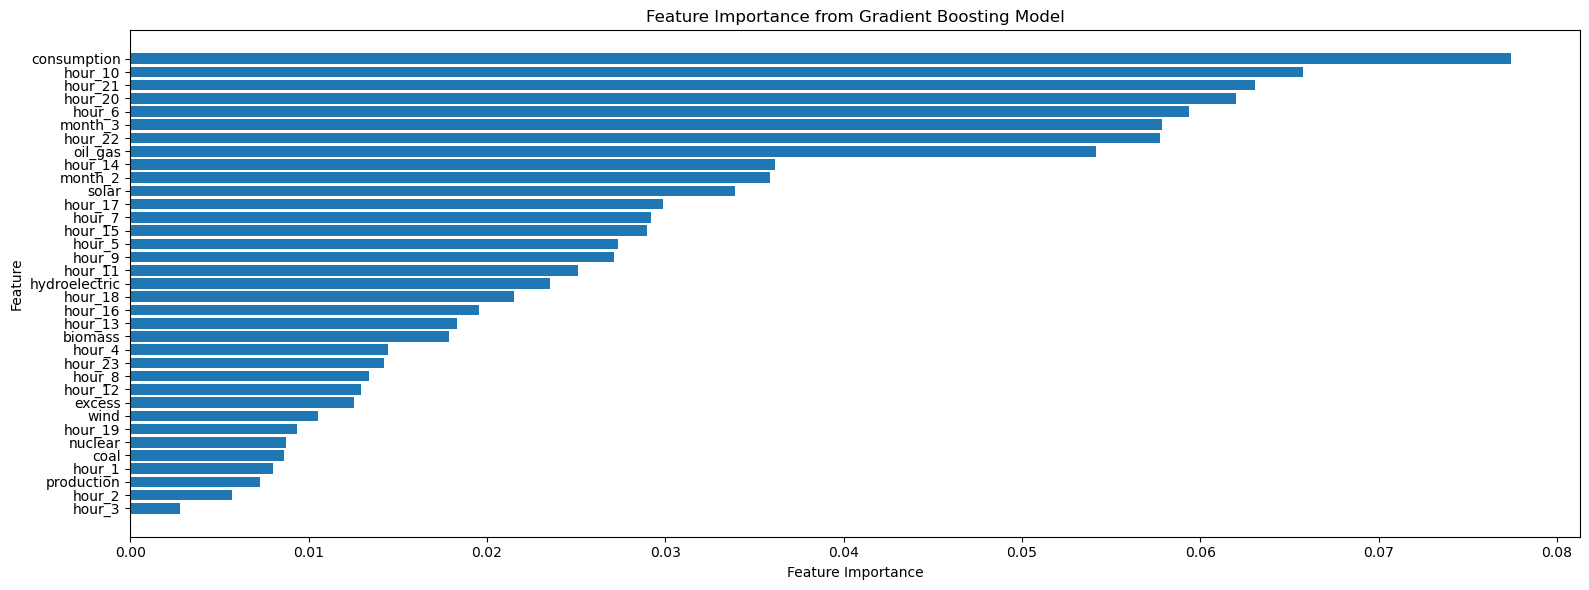

In [53]:
feature_names = X_train.columns

# Plot feature importances
plt.figure(figsize=(16, 6))
indices = np.argsort(importances)
plt.barh(range(len(importances)), importances[indices], align = 'center')
plt.yticks(range(len(importances)), feature_names[indices])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Gradient Boosting Model')
# Adjust layout
plt.tight_layout()
# Save
plt.savefig('../image/gb_importances2.png', dpi = 300, bbox_inches = 'tight')
# Show the plot
plt.show();

In [54]:
# Save the best model
best_model = best_xgbr
filename = '../model/electricity_cost.pkl'

with open(filename, 'wb') as file:
    pickle.dump(best_model, file)
    
print(f'Model saved to {filename}')

Model saved to ../model/electricity_cost.pkl
